# **Automatic Ticket Classification**
### CaseStudy By : Janarthanan Mani & Mohammed Faheem Uddin

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [16]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import files
uploaded = files.upload()

In [17]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
100% 83.4M/83.4M [00:00<00:00, 201MB/s]


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [18]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')   
# Write the path to your data file and load it  
# returns JSON object as  
# a dictionary 


## Data preparation

In [19]:
data = json.load(f)
df = pd.json_normalize(data)

In [20]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [21]:
#print the column names
for col in df.columns:
  print(col)


_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [22]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [23]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [24]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [25]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text



In [26]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
#Function to Lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)


In [28]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['source_complaint_what_happened'].apply(lambda x: clean_text(x))

In [29]:
df_clean['lemmatized_complaints'] = df_clean['complaints'].apply(lambda x: lemmatizer(x))

In [30]:
df_clean

,complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...


In [31]:
df_clean.to_csv('df_clean.csv', index=False)

In [32]:
#Write your function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [33]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['lemmatized_complaints'].apply(lambda x: pos_tag(x))

In [34]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom xxxx pr...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




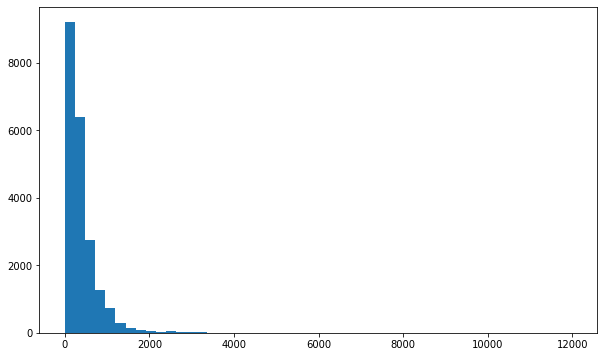

In [35]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

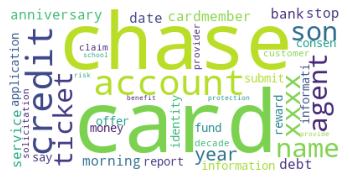

In [36]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [37]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [38]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [39]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df_unigram.iloc[:10,:]

,unigram,count
0,account,44970
1,chase,39166
2,credit,32339
3,card,29564
4,payment,20512
5,xxxx,16353
6,charge,15877
7,bank,15723
8,time,15676
9,day,12714


In [40]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [41]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram.iloc[:10,:]

,bigram,count
0,credit card,12332
1,credit report,3862
2,customer service,2838
3,account account,2419
4,chase credit,2337
5,account chase,2329
6,bank account,1922
7,debit card,1828
8,chase account,1793
9,check account,1788


In [42]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['complaints'], 30)

In [43]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram.iloc[:10,:]

,trigram,count
0,xxxx xxxx xxxx,37868
1,jp morgan chase,2284
2,chase credit card,1779
3,xxxx xxxx chase,1644
4,xxxxxxxx xxxx xxxx,1572
5,xxxx xxxx xxxxxxxx,1263
6,chase xxxx xxxx,1111
7,chase bank xxxx,1060
8,xxxx xxxxxxxx xxxx,954
9,account xxxx xxxx,908


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [44]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [45]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...,card report application submit identity consen...
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...


In [46]:
#Remove all rows where Complaints_clean column is nan
df_clean = df_clean[df_clean['Complaint_clean'].notnull()]

In [47]:
df_clean.to_csv('df_clean_final.csv', index=False)

In [48]:
## Code for internal purpose to reduce the execution time while preparing case study--commented
#df_clean = pd.read_csv('df_clean_final.csv')
#df_clean = df_clean[df_clean['Complaint_clean'].notnull()]
#df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized_complaints  21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
dtypes: object(4)
memory usage: 823.1+ KB


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [49]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
# Transform word vector in tfidf vector
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
tfidf = vectorizer.fit_transform(df_clean.Complaint_clean) 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [50]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vectorizer.fit_transform(df_clean['Complaint_clean'])#tfidf


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [51]:
from sklearn.decomposition import NMF

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

### 5 is chosen as best cluster based on data dictionary provided by Bank

In [53]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = 5, random_state = 100)

In [54]:
    def get_feature_names():
        """Array mapping from feature integer indices to feature name.
        Returns
        -------
        feature_names : list
            A list of feature names.
        """
        self._check_vocabulary()

        return [t for t, i in sorted(self.vocabulary_.items(), key=itemgetter(1))]

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [56]:
nmf_model.fit(dtm)
len(vectorizer.get_feature_names())

6514

In [57]:
#Print the Top15 words for each of the topics
# Create a DataFrame: topic_words
topic_words = pd.DataFrame(nmf_model.components_, columns=vectorizer.get_feature_names())

for i in range(topic_words.shape[0]):
    words = topic_words.iloc[i]
    print(f'For topic {i} the words with the highest value are:')
    print(words.nlargest(15))
    print('\n')   

topic_words

For topic 0 the words with the highest value are:
account        4.096558
check          2.110093
money          1.510107
bank           1.484745
fund           1.155239
deposit        1.004933
chase          0.993491
branch         0.772814
day            0.729655
number         0.579536
transaction    0.537487
business       0.535229
transfer       0.504876
claim          0.470356
customer       0.458322
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
credit         3.035070
card           2.231219
report         1.421925
inquiry        0.998626
chase          0.540534
account        0.505907
score          0.439920
company        0.396307
information    0.321111
limit          0.296240
application    0.293210
debt           0.292821
letter         0.282160
year           0.255327
balance        0.212273
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
payment      3.933589
balance      0.711090
month        0.597110
fee         

,aarp,abandon,abandonment,abatement,abet,abide,abiding,ability,abovementione,abovereference,abscond,absence,absolve,absorb,absurdity,abundance,abuse,abuser,ac,acccount,acceleration,accent,accept,acceptance,access,accessibility,accessory,accident,acco,accommodation,accomodation,accompany,accomplice,accomplish,accont,accord,accordance,accou,accouint,accound,...,worthiness,worthlessness,woudl,wouldbe,wound,wrangle,wrap,wreck,wrist,wristband,writ,write,writeoff,writer,writing,wrong,wrongdoe,wrongdoing,wthe,wwwchasecom,wwwjusticegovpaoverview_omb,xx,xxx,yard,yea,year,yearold,yell,yesterday,yield,yo,yoga,youth,yr,yrs,ys,ytd,zip,zombie,zone
0,0.000000,0.001680,0.00000,0.000229,0.000000,0.000461,0.000793,0.027905,0.000017,0.000000,0.000000,0.001380,0.000535,0.000000,0.000387,0.000000,0.021470,0.000000,0.002034,0.003868,0.000000,0.005620,0.006803,0.001368,0.330340,0.000513,0.000000,0.010298,0.000894,0.003004,0.000000,0.000212,0.000209,0.001068,0.000832,0.039428,0.003007,0.001544,0.000000,0.000000,...,0.000000,0.000000,0.001498,0.000372,0.000169,0.001017,0.000000,0.000204,0.000222,0.000301,0.000572,0.016738,0.000009,0.014577,0.014390,0.018421,0.000297,0.001545,0.000011,0.000000,0.000000,0.000000,0.000000,0.000153,0.000449,0.219004,0.000176,0.000493,0.054726,0.004451,0.000000,0.000000,0.000714,0.000000,0.000000,0.000000,0.000000,0.002148,0.000000,0.000000
1,0.001544,0.000125,0.00000,0.000000,0.000000,0.000372,0.000000,0.031537,0.000457,0.000000,0.000000,0.001467,0.001493,0.000623,0.000000,0.000000,0.009712,0.000459,0.000000,0.000000,0.000000,0.001130,0.000401,0.001617,0.022593,0.000433,0.000214,0.004181,0.000048,0.004598,0.000000,0.000000,0.000429,0.000000,0.000000,0.024565,0.009398,0.000201,0.001055,0.000111,...,0.015852,0.000233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000196,0.000270,0.000000,0.000000,0.032418,0.000791,0.000000,0.006524,0.003129,0.000000,0.000675,0.000411,0.000000,0.000103,0.000000,0.000000,0.000000,0.000551,0.255327,0.000534,0.000000,0.008799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.000702,0.000000,0.002626,0.000331,0.000000
2,0.000000,0.000000,0.00001,0.000340,0.000602,0.000000,0.000000,0.020704,0.000142,0.000117,0.000000,0.002957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000090,0.000000,0.000000,0.002269,0.000000,0.000057,0.004096,0.000000,0.000000,0.000000,0.013083,0.000000,0.006037,0.001173,0.000114,0.000022,0.000000,0.000000,0.030637,0.005616,0.000000,0.000000,0.000000,...,0.004250,0.000000,0.000000,0.000966,0.000000,0.000000,0.000000,0.002121,0.000000,0.000404,0.000000,0.000000,0.000250,0.000000,0.000997,0.012916,0.000000,0.000000,0.000263,0.001216,0.000000,0.000000,0.000998,0.000550,0.000000,0.182856,0.000000,0.000233,0.009392,0.000000,0.000000,0.000000,0.000000,0.002450,0.000416,0.000427,0.000168,0.004061,0.000000,0.002697
3,0.000000,0.000123,0.00000,0.000000,0.000413,0.000744,0.000000,0.006483,0.000322,0.000000,0.000000,0.000772,0.000000,0.000291,0.000807,0.001230,0.011437,0.000000,0.000694,0.000000,0.000000,0.003747,0.000102,0.000499,0.001673,0.000000,0.001399,0.001747,0.000681,0.000075,0.000953,0.000048,0.000159,0.000000,0.000496,0.028743,0.002142,0.000101,0.000000,0.000584,...,0.000000,0.000574,0.000000,0.000000,0.000150,0.000432,0.001492,0.000000,0.000324,0.000913,0.000134,0.007783,0.000000,0.000000,0.021302,0.007523,0.000752,0.001604,0.000000,0.000034,0.000000,0.000648,0.000129,0.000163,0.000822,0.067685,0.000000,0.000431,0.029226,0.001066,0.001865,0.000878,0.000000,0.002305,0.000000,0.000013,0.000752,0.002960,0.000582,0.002590
4,0.000000,0.002964,0.00116,0.001533,0.000000,0.000610,0.000000,0.040207,0.000312,0.000245,0.000673,0.001702,0.000000,0.000061,0.000492,0.000833,0.027937,0.000159,0.001946,0.000000,0.002412,0.001326,0.001291,0.008760,0.011607,0.000540,0.001153,0.011656,0.000000,0.000466,0.000000,0.002212,0.000241,0.000084,0.001139,0.047909,0.011770,0.000000,0.000292,0.000069,...,0.001875,0.000000,0.000085,0.000471,0.000510,0.000000,0.002488,0.002697,0.000000,0.000000,0.0

In [58]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)


array([0, 1, 1, ..., 3, 2, 2])

In [59]:
#Assign the best topic to each of the complaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [60]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...,card report application submit identity consen...,1
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,3
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,3
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...,2


In [61]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict -PRON...,notice account card branch customer service re...,notice account card branch customer service re...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account,mishandle account,0
27,i opened an account with chase bank on xxxx an...,i open an account with chase bank on xxxx and ...,account code bonus xxxxxxxx term account xxxx ...,account code bonus term account deposit bonu...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...,card report application submit identity consen...,1
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
15,can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,chase credit card credit report company help i...,chase credit card credit report company help i...,1


In [62]:
df_clean.Topic.value_counts()

0    5176
1    5043
3    4710
4    3894
2    2249
Name: Topic, dtype: int64

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [63]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan",
               2:"Others"
                }
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [64]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Bank Account services
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or prepaid card
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...,card report application submit identity consen...,Credit card or prepaid card
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...,Others


In [65]:
df_clean.Topic.value_counts()

Bank Account services          5176
Credit card or prepaid card    5043
Theft/Dispute Reporting        4710
Mortgage/Loan                  3894
Others                         2249
Name: Topic, dtype: int64

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [66]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [67]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,i upgrade -PRON- xxxx xxxx card in xxxx and be...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card report application submit identity consen...,card report application submit identity consen...,1
11,on xxxx while trying to book a xxxx xxxx tic...,on xxxx while try to book a xxxx xxxx tick...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
14,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...,son chase account fund account money say son c...,son chase account fund account money say son c...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i call chas -PRON- xxxx ...,card provider claim protection benefit school ...,card provider claim protection benefit school ...,3
78310,i am not familiar with xxxx pay and did not un...,i be not familiar with xxxx pay and do not und...,risk provide consumer chase year trust banking...,risk provide consumer chase year trust banking...,3
78311,i have had flawless credit for yrs ive had ch...,i have have flawless credit for yrs -PRON- h...,credit chase credit card chase freedom xxxx pr...,credit chase credit card chase freedom proble...,2


In [68]:
df_clean.to_csv('df_clean_premodel.csv', index=False)

In [69]:
## Code for internal purpose to reduce the execution time while preparing case study--commented
#df_clean = pd.read_csv('df_clean_premodel.csv')
#df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaints             21072 non-null  object
 1   lemmatized_complaints  21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   Complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 987.8+ KB


In [70]:
#Keep the columns"complaints" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaints","Topic"]]

In [71]:
training_data

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,1
10,chase card was reported on xxxx however fraudu...,1
11,on xxxx while trying to book a xxxx xxxx tic...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [72]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [73]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")



Shape of X_train: (15804, 33227)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33227)
Shape of y_test: (5268,)


# Using Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [75]:
y_train_pred = dt_base.predict(X_train)
y_test_pred = dt_base.predict(X_test)

In [76]:
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft Reporting","Mortgage/Loan"]
print(classification_report(y_test, y_test_pred,target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.73      0.61      0.67      1315
Credit card or prepaid card       0.78      0.77      0.77      1294
                     Others       0.77      0.56      0.65       548
            Theft Reporting       0.46      0.80      0.59      1161
              Mortgage/Loan       0.91      0.49      0.64       950

                   accuracy                           0.66      5268
                  macro avg       0.73      0.64      0.66      5268
               weighted avg       0.72      0.66      0.67      5268



### Hyper-parameter tuning for the Decision Tree

In [77]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [78]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished


CPU times: user 6.71 s, sys: 154 ms, total: 6.87 s
Wall time: 2min 2s


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         

In [79]:
grid_search.best_score_

0.7954948114401418

In [80]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

## Evalution Score of Decision Tree with Hyperparameter Tuning

In [81]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)
print(classification_report(y_test, y_test_pred,target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.81      0.81      0.81      1315
Credit card or prepaid card       0.82      0.83      0.83      1294
                     Others       0.78      0.75      0.76       548
            Theft Reporting       0.78      0.75      0.77      1161
              Mortgage/Loan       0.79      0.83      0.81       950

                   accuracy                           0.80      5268
                  macro avg       0.80      0.79      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



# Using Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [83]:
%%time
rf.fit(X_train, y_train)

CPU times: user 136 ms, sys: 6.99 ms, total: 143 ms
Wall time: 142 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=100, verbose=0,
                       warm_start=False)

In [84]:
rf.oob_score_

0.24841812199443178

### Hyper-parameter tuning for the Random Forest

In [85]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [86]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.6min finished


CPU times: user 12.9 s, sys: 304 ms, total: 13.2 s
Wall time: 4min 41s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [87]:
grid_search.best_score_

0.7624019235636549

In [88]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Evalution Score of Random Forest with Hyperparameter Tuning

In [89]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_test_pred,target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.76      0.90      0.82      1315
Credit card or prepaid card       0.72      0.86      0.78      1294
                     Others       0.96      0.18      0.30       548
            Theft Reporting       0.79      0.80      0.80      1161
              Mortgage/Loan       0.86      0.79      0.83       950

                   accuracy                           0.77      5268
                  macro avg       0.82      0.71      0.71      5268
               weighted avg       0.80      0.77      0.75      5268



# Using Naive Bayes

In [90]:
from sklearn.naive_bayes import GaussianNB
# instantiate the model
gnb = GaussianNB()

In [91]:
X_train=X_train.todense()
X_test=X_test.todense()

In [92]:
# fit the model
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [93]:
y_pred = gnb.predict(X_test)

y_pred

array([0, 0, 4, ..., 1, 0, 3])

### Check accuracy score

In [94]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.3464


In [95]:
from sklearn.metrics import classification_report
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft Reporting","Mortgage/Loan"]
print(classification_report(y_test, y_pred,target_names=target_names))

                             precision    recall  f1-score   support

      Bank Account services       0.44      0.28      0.34      1315
Credit card or prepaid card       0.38      0.32      0.35      1294
                     Others       0.15      0.46      0.23       548
            Theft Reporting       0.44      0.32      0.37      1161
              Mortgage/Loan       0.50      0.46      0.48       950

                   accuracy                           0.35      5268
                  macro avg       0.38      0.36      0.35      5268
               weighted avg       0.41      0.35      0.36      5268



# Model Inference

#### "Bank Account services":0
#### "Credit card or prepaid card":1
####  "Mortgage/Loan":2
#### "Theft/Dispute Reporting":3
#### "Others":4



In [96]:
Topic_names = {0:" Bank Account services",
               1:"Credit card or prepaid card",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan",
               2:"Others" }

In [97]:
my_complaint = """Credit card is stolen"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_complaint])
# Predict: nmf_features
nmf_features = nmf_model.transform(X)
print("NMF Prediction =",pd.DataFrame(nmf_features).idxmax(axis=1).map(Topic_names).iloc[0])
X = count_vect.transform([my_complaint])
nmf_features = gnb.predict(X.todense())
print("Naive Bayes Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = rf_best.predict(X)
print("Random Forest Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = dt_best.predict(X)
print("Decision Tree Model Prediction =",Topic_names[nmf_features[0]])
 


NMF Prediction = Credit card or prepaid card
Naive Bayes Model Prediction = Others
Random Forest Model Prediction = Credit card or prepaid card
Decision Tree Model Prediction = Credit card or prepaid card


In [98]:
my_complaint = """My savings account is debited twice"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_complaint])
# Predict: nmf_features
nmf_features = nmf_model.transform(X)
print("NMF Prediction =",pd.DataFrame(nmf_features).idxmax(axis=1).map(Topic_names).iloc[0])
X = count_vect.transform([my_complaint])
nmf_features = gnb.predict(X.todense())
print("Naive Bayes Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = rf_best.predict(X)
print("Random Forest Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = dt_best.predict(X)
print("Decision Tree Model Prediction =",Topic_names[nmf_features[0]])

NMF Prediction =  Bank Account services
Naive Bayes Model Prediction = Others
Random Forest Model Prediction =  Bank Account services
Decision Tree Model Prediction =  Bank Account services


In [99]:
my_complaint = """Home loan account interest rate is high"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_complaint])
# Predict: nmf_features
nmf_features = nmf_model.transform(X)
print("NMF Prediction =",pd.DataFrame(nmf_features).idxmax(axis=1).map(Topic_names).iloc[0])
X = count_vect.transform([my_complaint])
nmf_features = gnb.predict(X.todense())
print("Naive Bayes Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = rf_best.predict(X)
print("Random Forest Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = dt_best.predict(X)
print("Decision Tree Model Prediction =",Topic_names[nmf_features[0]])

NMF Prediction = Mortgage/Loan
Naive Bayes Model Prediction = Others
Random Forest Model Prediction = Mortgage/Loan
Decision Tree Model Prediction = Mortgage/Loan


In [100]:
my_complaint = """Dispute on my credit card transaction"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_complaint])
# Predict: nmf_features
nmf_features = nmf_model.transform(X)
print("NMF Prediction =",pd.DataFrame(nmf_features).idxmax(axis=1).map(Topic_names).iloc[0])
X = count_vect.transform([my_complaint])
nmf_features = gnb.predict(X.todense())
print("Naive Bayes Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = rf_best.predict(X)
print("Random Forest Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = dt_best.predict(X)
print("Decision Tree Model Prediction =",Topic_names[nmf_features[0]])

NMF Prediction = Credit card or prepaid card
Naive Bayes Model Prediction = Others
Random Forest Model Prediction = Credit card or prepaid card
Decision Tree Model Prediction = Credit card or prepaid card


In [101]:
my_complaint = """xxxx is good"""
 
# Transform the TF-IDF
X = vectorizer.transform([my_complaint])
# Predict: nmf_features
nmf_features = nmf_model.transform(X)
print("NMF Prediction =",pd.DataFrame(nmf_features).idxmax(axis=1).map(Topic_names).iloc[0])
X = count_vect.transform([my_complaint])
nmf_features = gnb.predict(X.todense())
print("Naive Bayes Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = rf_best.predict(X)
print("Random Forest Model Prediction =",Topic_names[nmf_features[0]])
nmf_features = dt_best.predict(X)
print("Decision Tree Model Prediction =",Topic_names[nmf_features[0]])

NMF Prediction = Theft/Dispute Reporting
Naive Bayes Model Prediction = Others
Random Forest Model Prediction = Credit card or prepaid card
Decision Tree Model Prediction = Mortgage/Loan


# Conclusion

#### ***-Decision Tree Model is good in prediction with 81% accuracy***
#### ***-Random Forest is better in prediction with 77% accuracy***
#### ***-Naive Bayes is not doing good with 35% accuracy***